© 2025 Zitao Yang, Rebecca J. Rousseau, Sara D. Mahdavi, Hernan G. Garcia, and Rob Phillips, *The Dynamics of Inducible Genetic Circuits*. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).
___

# Dynamics of Auto-Activation

This notebook generates the results shown in Figures 8, 9, and 10 of the paper, which evaluate how dynamics evolve with effector concentration. The evolution of activator expression is defined by the dimensionless dynamical equation

$$ \frac{d\bar{A}}{d\bar{t}} = - \bar{A} + \frac{\bar{r}_0 + \bar{r}_1 (2p_\text{act}\bar{A}) + \bar{r}_2 \omega (p_\text{act}\bar{A})^2}{1+2p_\text{act}\bar{A} + \omega (p_\text{act}\bar{A})^2}.$$

## General helper functions

In [1]:
import numpy as np
import numpy.random as rng
import matplotlib.pyplot as plt
import math
import param
from scipy.signal import find_peaks
import scipy.optimize
from sympy import *

# Figure formatting

SMALL_SIZE = 15
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['text.usetex'] = True           # use LaTeX rendering for plot text
plt.rcParams['mathtext.fontset'] = 'stix'    # math font size
plt.rcParams['font.family'] = 'STIXGeneral'  # font style
plt.rcParams['axes.labelpad'] = 8.0

# Helper function

def pAct(C, Ka=1.4*10**(-4), Ki=5.3*10**(-7), delE=4.5):
    """ Probability of repressor/activator being active
    
    Arguments:
        - C: effector concentration
        - Ka: dissociation constant in active state
        - Ki: dissociation constant in inactive state
        - delE: energy difference between inactive and active state
    """

    p = (1 + C/Ka)**2 / ((1 + C/Ka)**2 + np.exp(-delE)*(1 + C/Ki)**2)
    return p

## Fig. 8

This figure plots the production and degradation rates for an auto-activation switch as a function of activator concentration at a specific effector concentration (with cooperativity and rate parameter values fixed). Intersections of the two curves denote stable and unstable fixed points.

## Helper functions

In [3]:
def prodautoact(A, p, r0, r1, r2, w):
    """Determine the concentration of activator produced in a given time step

    Arguments:
        - A: dimensionless concentration of activator
        - p: p_act, probability of A being active
        - r0: r_0, basal rate of activator mRNA expression, i.e., expression rate
          for unbound regulatory state (dimensionless)
        - r1: r_1, rate of activator mRNA expression in regulatory state with
          one bound activator (dimensionless)
        - r2: r_2, rate of activator mRNA expression in regulatory state with
          two bound activators (dimensionless)
        - w: cooperativity
          
    Returns: activator concentration
    """
    return r0/(1 + 2*(p*A) + w*(p*A)**2) + r1*(2*p*A)/(1 + 2*(p*A) + w*(p*A)**2) + \
            r2*(w*(p*A)**2)/(1 + 2*(p*A) + w*(p*A)**2)

def degautoact(A):
    """Determine the concentration of activator degraded in a given time step

    Arguments:
        - A: dimensionless concentration of activator
        
    Returns: activator concentration
    """
    return A

def f(p, r0, r1, r2, w):
    """Determine the change in activator concentration in a given time step.
    This is prodautoact - degautoat written to allow for symbolic manipulation
    by symbol 'z'

    Arguments:
        - p: p_act, probability of A being active
        - r0: r_0, basal rate of activator mRNA expression, i.e., expression rate
          for unbound regulatory state (dimensionless)
        - r1: r_1, rate of activator mRNA expression in regulatory state with
          one bound activator (dimensionless)
        - r2: r_2, rate of activator mRNA expression in regulatory state with
          two bound activators (dimensionless)
        - w: cooperativity
          
    Returns: change in the concentration of activator as a function of current
    activator concentration z
    """
    return r0/(1 + 2*(p*z) + w*(p*z)**2) + r1*(2*p*z)/(1 + 2*(p*z) + w*(p*z)**2) + \
            r2*(w*(p*z)**2)/(1 + 2*(p*z) + w*(p*z)**2) - z
z = Symbol('z')

def steadyStateAutoActivation(p, r0, r1, r2, w):
    """Find the auto-activation steady states given parameters

    Arguments:
        - p: p_act, probability of A being active
        - r0: r_0, basal rate of activator mRNA expression, i.e., expression rate
          for unbound regulatory state (dimensionless)
        - r1: r_1, rate of activator mRNA expression in regulatory state with
          one bound activator (dimensionless)
        - r2: r_2, rate of activator mRNA expression in regulatory state with
          two bound activators (dimensionless)
        - w: cooperativity
          
    Returns: steady state activator concentrations
    """
    coeff = [w*p**2, 2*p-r2*w*p**2, 1-2*r1*p, -r0]

    return np.roots(coeff)

We now define the activator production and degradation curves for a system with a fixed set of parameters, and calculate the fixed points and their stability in this setting.

In [5]:
# Define probability of activity, rates, and cooperativity

Cs = np.logspace(-5.5, -4, 1000)
p_acts = pAct(Cs)

r0, r1, r2 = 0.1, 1, 20
w = 10

# Create gridspace

length = 2000;
x = np.logspace(-2.5, 2.5, length) # x-axis: dimensionless activator concentration
y = np.logspace(-2.5, 0, length) # y-axis: rate of production/degradation
X, Y = np.meshgrid(x,y)

# Calculate production and degradation rates at each point in gridspace for chosen probability of activity, here p_acts[600]
Dx = prodautoact(x, p=p_acts[600], r0=r0, r1=r1, r2=r2, w=w)
Dy = degautoact(A=x)

# Calculate fixed points and stability

Rs = steadyStateAutoActivation(p=p_acts[600], r0=r0, r1=r1, r2=r2, w=w)
real_Rs = np.real(Rs[np.isreal(Rs)])
fixed_points = real_Rs[real_Rs >= 0]

ff = f(p=p_acts[600], r0=r0, r1=r1, r2=r2, w=w)
dfdx = diff(ff, z)
fpval = []
stab = []
for i in range(len(fixed_points)):  
    # Define rates at each fixed point
    yval = prodautoact(A=fixed_points[i], p=p_acts[600], r0=r0, r1=r1, r2=r2, w=w)
    fpval.append(yval)
    # Define stability at each fixed point
    lambdaval = dfdx.subs(z, fixed_points[i])
    if lambdaval < 0:
        stab.append(0) # stable
    else:
        stab.append(1) # unstable

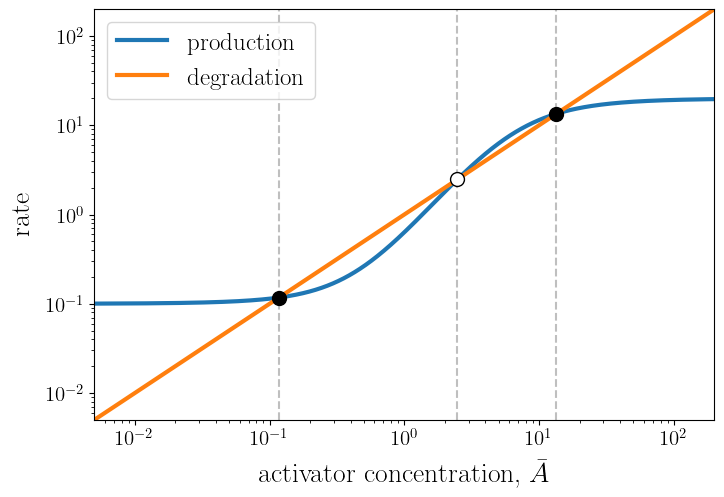

In [7]:
# Plot

bottomlim = 10**(-2.3)
toplim = 10**(2.3)
plt.figure(figsize=(8, 16/3)) # 6 x 4 standard)
plt.plot(x, Dx, linewidth=3, label="production", color="#1f77b4")
plt.plot(x, Dy, linewidth=3, label="degradation", color="#ff7f0e")
for i in range(len(fixed_points)):
    plt.axvline(x = fixed_points[i], color = 'k',linestyle = '--',alpha=0.25)
    if stab[i]==0:
        plt.plot(fixed_points[i], fpval[i], 'o', markersize=10, markerfacecolor='black', markeredgecolor='black')
    else:
        plt.plot(fixed_points[i], fpval[i], 'o', markersize=10, markerfacecolor='white', markeredgecolor='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"activator concentration, $\bar{A}$")
plt.ylabel(r"rate")
plt.ylim(bottomlim, toplim)
plt.xlim(bottomlim, toplim)
plt.legend()
plt.show()

## Fig. 9

This figure plots the bifurcation diagram for auto-activation, demonstrating thresholds in effector concentration at which the number of fixed points/stability profile changes. We first plot the bifurcation diagram itself, and then plot a version of Fig. 8 at different effector concentrations along the graph. The effector concentrations chosen for production/degradation plots are denoted by vertical dashed lines in the first plot generated below.

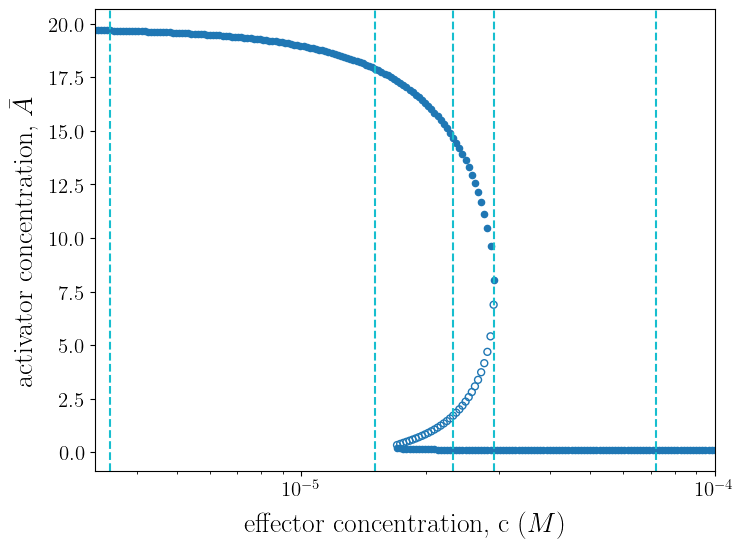

In [9]:
fig, ax = plt.subplots(figsize=(8,6))

# Define probability of activity (note: same rates and cooperativity as in the previous figure)

length = 200
Cs = np.logspace(-5.5, -4, length)
p_acts = pAct(Cs)

# At each effector concentration in Cs, solve for the steady-states and determine their stabilities

stab = []
unstab = []
positive_Cs_stable = []
positive_Cs_unstable = []
for i in range(len(p_acts)):
    Rs = steadyStateAutoActivation(p=p_acts[i], r0=r0, r1=r1, r2=r2, w=w)
    real_Rs = np.real(Rs[np.isreal(Rs)])
    fixed_points = real_Rs[real_Rs >= 0]
    ff = f(p=p_acts[i], r0=r0, r1=r1, r2=r2, w=w)
    dfdx = diff(ff, z)
    fpval = []
    for j in range(len(fixed_points)):  
        # Define rates at each fixed point
        yval = prodautoact(A=fixed_points[j], p=p_acts[i], r0=r0, r1=r1, r2=r2, w=w)
        fpval.append(yval)
        # Define stability at each fixed point
        lambdaval = dfdx.subs(z, fixed_points[j])
        if np.isreal(yval) == True and yval >= 0:
            if lambdaval < 0:
                stab.append(yval) # stable
                positive_Cs_stable.append(Cs[i])
            else:
                unstab.append(yval) # unstable
                positive_Cs_unstable.append(Cs[i])

# Plot

ax.scatter(positive_Cs_stable, stab, s=20, marker='o')
ax.scatter(positive_Cs_unstable, unstab, s=25, marker='o', facecolors = 'none', edgecolors = 'tab:blue')

# Optional: can denote the specific timepoints along the bifurcation diagram that will be plotted in the next part of Fig. 9.
ax.axvline(x=Cs[5], linestyle='--', color='tab:cyan')
ax.axvline(x=Cs[90], linestyle='--', color='tab:cyan')
ax.axvline(x=Cs[115], linestyle='--', color='tab:cyan')
ax.axvline(x=Cs[128], linestyle='--', color='tab:cyan')
ax.axvline(x=Cs[180], linestyle='--', color='tab:cyan')

ax.set_xlabel(r"effector concentration, c $(M)$")
ax.set_ylabel(r"activator concentration, $\bar{A}$")
ax.set_xlim(10**(-5.5), 10**(-4))
plt.xscale("log")
plt.show()

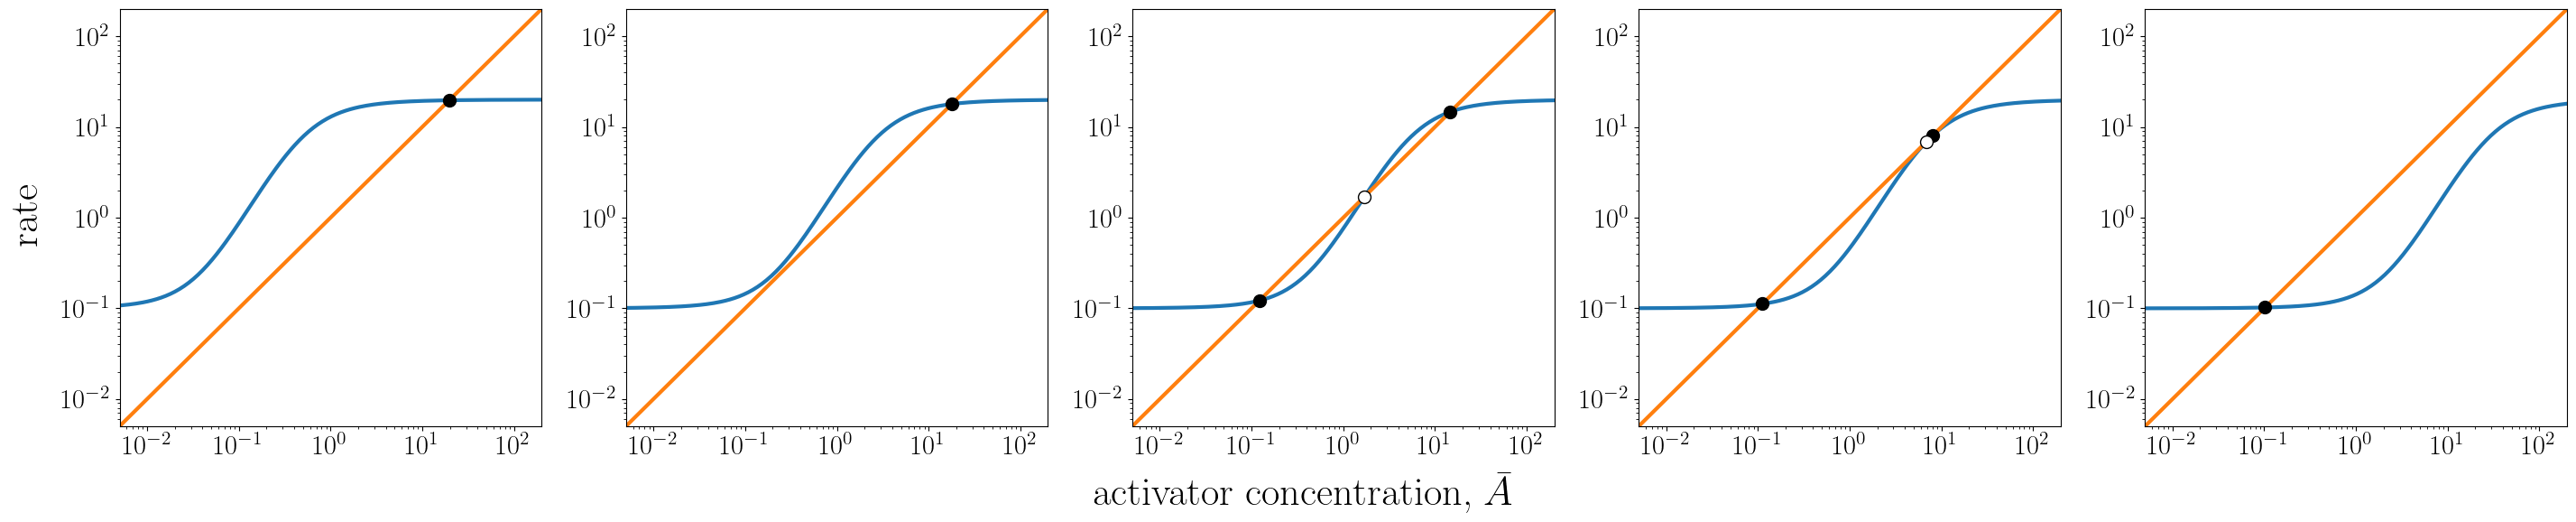

In [13]:
# Plot production and degradation rates of the system at various effector concentrations (denoted by vertical dashed lines in the above plot)
# for fixed rates/cooperativity. Note that the plots generated here are ordered by increasing effector concentration left to right

# Create gridspace

x = np.logspace(-2.5, 2.5, length) # x-axis: dimensionless activator concentration
y = np.logspace(-2.5, 0, length) # y-axis: rate of production/degradation
X, Y = np.meshgrid(x,y)

# selected effector concentrations from above plot
tslice = [5, 90, 115, 128, 180]

fig, ax = plt.subplots(1,len(tslice), figsize=(35, 6))

for i in range(len(tslice)):

    # Calculate production and degradation rates at each point in gridspace for the given probability of activity
    Dx = prodautoact(x, p=p_acts[tslice[i]], r0=r0, r1=r1, r2=r2, w=w)
    Dy = degautoact(A=x)
    
    # Calculate fixed points and stability
    
    Rs = steadyStateAutoActivation(p=p_acts[tslice[i]], r0=r0, r1=r1, r2=r2, w=w)
    real_Rs = np.real(Rs[np.isreal(Rs)])
    fixed_points = real_Rs[real_Rs >= 0]

    ff = f(p=p_acts[tslice[i]], r0=r0, r1=r1, r2=r2, w=w)
    dfdx = diff(ff, z)
    fpval = []
    stabslice = []
    for j in range(len(fixed_points)):  
        # Define rates at each fixed point
        yval = prodautoact(A=fixed_points[j], p=p_acts[tslice[i]], r0=r0, r1=r1, r2=r2, w=w)
        fpval.append(yval)
        # Define stability at each fixed point
        lambdaval = dfdx.subs(z, fixed_points[j])
        if lambdaval < 0:
            stabslice.append(0) # stable
        else:
            stabslice.append(1) # unstable

    # PLOT
    bottomlim = 10**(-2.3)
    toplim = 10**(2.3)
    ax[i].plot(x, Dx, linewidth=3, label="production", color="#1f77b4")
    ax[i].plot(x, Dy, linewidth=3, label="degradation", color="#ff7f0e")
    for j in range(len(fixed_points)):
        if stabslice[j]==0:
            ax[i].plot(fixed_points[j], fpval[j], 'o', markersize=10, markerfacecolor='black', markeredgecolor='black')
        else:
            ax[i].plot(fixed_points[j], fpval[j], 'o', markersize=10, markerfacecolor='white', markeredgecolor='black')
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_ylim(bottomlim, toplim)
    ax[i].set_xlim(bottomlim, toplim)
    ax[i].tick_params(axis='x', labelsize=22)
    ax[i].tick_params(axis='y', labelsize=22)
fig.supxlabel(r"activator concentration, $\bar{A}$", y=-0.05, fontsize=32)
fig.supylabel(r"rate", x=0.09, fontsize=32)
plt.show()

## Fig. 10

This figure highlights the phenomenon of hysteresis. In addition to the bifurcation diagram plotted in Fig. 9 above, we plot two paths for stable state evolution to demonstrate differences in the threshold at which the system switches from one stable steady state to another. This difference arrives from history-dependence.

## Helper function

In [15]:
def AutoActEvolve(p, z, r0, r1, r2, w):
    """ Determine the change in activator concentration in a given time step. This is a version of the function "f"
    defined earlier in the notebook, but now allows for direct substitution of activator concentration into argument "z."
    From this function, we numerically evolve activator expression to steady state at a given effector concentration

    Arguments:
        - p: p_act, probability of A being active
        - z: dimensionless activator concentration
        - r0: r_0, basal rate of activator mRNA expression, i.e., expression rate
          for unbound regulatory state (dimensionless)
        - r1: r_1, rate of activator mRNA expression in regulatory state with
          one bound activator (dimensionless)
        - r2: r_2, rate of activator mRNA expression in regulatory state with
          two bound activators (dimensionless)
        - w: cooperativity
          
    Returns: activator concentration
    """
    return r0/(1 + 2*(p*z) + w*(p*z)**2) + r1*(2*p*z)/(1 + 2*(p*z) + w*(p*z)**2) + \
            r2*(w*(p*z)**2)/(1 + 2*(p*z) + w*(p*z)**2) - z

We now demonstrate hysteresis in the bifurcation diagram from Fig. 9.

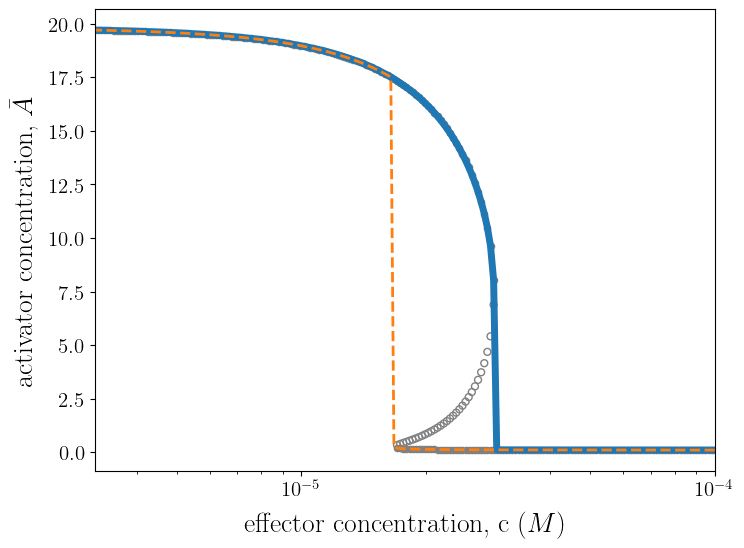

In [17]:
# Demonstrate hysteresis in the bifurcation diagram

# Define probability of activity (note: same rates and cooperativity as in the previous figures)

length = 200
Cs = np.logspace(-5.5, -4, length)
p_acts = pAct(Cs)

# Path 1: Consider a system that begins at a stable steady state with a high activator concentration.
# At each effector concentration, the system evolves to a new stable steady state, and this becomes
# the new starting point for subsequent increase in the effector concentration

Rstab = []
Rstab.insert(0, r2)

tstep = 0.001
steps = 100000

for i in range(len(p_acts)):
    for j in range(steps):
        prod = AutoActEvolve(p=p_acts[i],z=Rstab[i],r0=r0, r1=r1,r2=r2,w=w)
        Rnew = Rstab[i] + (prod*tstep)
        Rstab[i] = Rnew
    if i < len(p_acts)-1:
        Rstab.append(Rstab[i])

# Path 2: Now follow the reverse path. Consider a system that begins at a stable steady state with a low
# activator concentration. At each effector concentration, the system evolves to a new stable steady state,
# and this becomes the new starting point for subsequent decrease in the effector concentration

Csflip = np.flip(Cs)
p_actsflip = pAct(Csflip)

Rstabrev = []
Rstabrev.insert(0, 0)

for i in range(len(p_actsflip)):
    for j in range(steps):
        prod = AutoActEvolve(p=p_actsflip[i],z=Rstabrev[i],r0=r0, r1=r1,r2=r2,w=w)
        Rnewrev = Rstabrev[i] + (prod*tstep)
        Rstabrev[i] = Rnewrev
    if i < len(p_actsflip)-1:
        Rstabrev.append(Rstabrev[i])

realRstab = np.array(Rstab)

realRstabrev = np.array(Rstabrev)

# Plot

fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(positive_Cs_stable, stab, s=20, marker='o', facecolors = 'grey', edgecolors = 'grey')
ax.scatter(positive_Cs_unstable, unstab, s=25, marker='o', facecolors = 'none', edgecolors = 'grey')

ax.plot(Cs, realRstab, lw=5)
ax.plot(Csflip, realRstabrev, lw=2, ls='--')
ax.set_xlabel(r"effector concentration, c $(M)$")
ax.set_ylabel(r"activator concentration, $\bar{A}$")
plt.xscale("log")
plt.xlim(min(Cs), max(Cs))
plt.show()    

Note that the blue path follows the change in stable steady state reached as the effector concentration *increases*, and the orange dashed path follows the change in stable steady state reached as the effector concentration *decreases*.